# Modeling the Major Indices: 
- S&P 500
- Nasdaq
- Dow Jones
- Russell 2000

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier

import xgboost
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)

In [184]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

# Try this later

In [ ]:
# import warnings

# # Define a filter to suppress the specific scikit-learn warnings
# def custom_filter(action, category, module, lineno, file, line):
#     if "sklearn" in module and "FutureWarning" in category:
#         return None
#     return action(category, None, None, None, None)

# # Apply the custom filter
# warnings.filterwarnings(custom_filter)


### Importing Data

In [6]:
df = pd.read_csv("./Files/Indeces_Final.csv")
df.head(2)

,Date,Index,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1992-12-22,^DJI,3321.100098,3321.100098,3328.939941,3301.649902,3312.500000,25970000,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86248.9695,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0
1,1992-12-22,^GSPC,440.309998,440.309998,441.640015,438.250000,440.700012,250430000,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110266.8327,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0


### Missing Data
The missing data is exclusively due to the features that I have engineered. Technical indicators intially require a fixed window of time to generate, and logically for recent history, it is impossible to label the outcomes of dates that have yet to pass. Therefore, there is data missing in terms of technical indicators at the beginning of our set, and there is data missing on the back end of our data due to the unknown 1/3/6/12 month returns.

In [14]:
# Shows the amount of data to be dropped in order to consolidate everything into null-free data

df.shape[0], df.shape[0] - df.dropna().shape[0]

(31068, 1104)

In [16]:
df.head(2)

,Date,Index,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1992-12-22,^DJI,3321.100098,3321.100098,3328.939941,3301.649902,3312.500000,25970000,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86248.9695,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0
1,1992-12-22,^GSPC,440.309998,440.309998,441.640015,438.250000,440.700012,250430000,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110266.8327,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0


### In order to maintain the maximum amount of data...
I will partition the data based on the logistic regression target for future returns. The more data that I have for each individual set the better the models that we can create. We do not need the future dates at all, so they will be dropped from each of the DataFrame objects, and only the appropriate target value WILL NOT be dropped.

In [17]:
# Unique DF's based on the target time horizon 

one_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later', 'Three_Month_Positive', 'Six_Month_Positive', 'Twelve_Month_Positive'])
three_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later', 'One_Month_Positive', 'Six_Month_Positive', 'Twelve_Month_Positive'])
six_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive'])
twelve_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive'])

### Nulls dropped for the various time horizons

In [29]:
print("Total Data:", df.shape)
print("NULLS TO BE DROPPED:")
print("One Month: Total", one_month_df.shape[0], "|  Dropped", one_month_df.shape[0] - one_month_df.dropna().shape[0])
print("Three Month: Total", three_month_df.shape[0], "|  Dropped", three_month_df.shape[0] - three_month_df.dropna().shape[0])
print("Six Month: Total", six_month_df.shape[0], "|  Dropped", six_month_df.shape[0] - six_month_df.dropna().shape[0])
print("Twelve Month: Total", twelve_month_df.shape[0], "|  Dropped", twelve_month_df.shape[0] - twelve_month_df.dropna().shape[0])

Total Data: (31068, 33)
NULLS TO BE DROPPED:
One Month: Total 31068 |  Dropped 344
Three Month: Total 31068 |  Dropped 360
Six Month: Total 31068 |  Dropped 608
Twelve Month: Total 31068 |  Dropped 1104


##### Given that the largest Percentage of Null Data: 0.035534955581305525 is in the Twelve Month Target group, I feel that dropping the null values will likely not have too overt of an impact on the subsequent models that are created.

In [33]:
# Removing Nulls

one_month_df.dropna(inplace=True)
three_month_df.dropna(inplace=True)
six_month_df.dropna(inplace=True)
twelve_month_df.dropna(inplace=True)

In [38]:
# Resetting the Indexes

one_month_df.set_index("Date", inplace=True)
three_month_df.set_index("Date", inplace=True)
six_month_df.set_index("Date", inplace=True)
twelve_month_df.set_index("Date", inplace=True)

In [40]:
# For Verification

twelve_month_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29964 entries, 1993-01-28 to 2022-10-25
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index                  29964 non-null  object 
 1   Adj Close              29964 non-null  float64
 2   Close                  29964 non-null  float64
 3   High                   29964 non-null  float64
 4   Low                    29964 non-null  float64
 5   Open                   29964 non-null  float64
 6   Volume                 29964 non-null  int64  
 7   garman_klass_vol       29964 non-null  float64
 8   RSI                    29964 non-null  float64
 9   lowest_bollinger_band  29964 non-null  float64
 10  lower_bollinger_band   29964 non-null  float64
 11  20_day_SMA             29964 non-null  float64
 12  one_up_bollinger_band  29964 non-null  float64
 13  upper_bollinger_band   29964 non-null  float64
 14  ATR                    29964 non-null  float6

# Breaking data into index groups

In [48]:
# Entries per index -> going back to 1993

df["Index"].value_counts()

Index
^DJI     7767
^GSPC    7767
^IXIC    7767
^RUT     7767
Name: count, dtype: int64

### Dow Jones

In [49]:
# Different groups for each respective target time horizon

dow_one_month = one_month_df[one_month_df["Index"] == "^DJI"]
dow_three_month = three_month_df[three_month_df["Index"] == "^DJI"]
dow_six_month = six_month_df[six_month_df["Index"] == "^DJI"]
dow_twelve_month = twelve_month_df[twelve_month_df["Index"] == "^DJI"]

In [51]:
dow_one_month.shape, dow_twelve_month.shape

((7681, 25), (7491, 25))

### S&P 500

In [54]:
# Different groups for each respective target time horizon

SnP_one_month = one_month_df[one_month_df["Index"] == "^GSPC"]
SnP_three_month = three_month_df[three_month_df["Index"] == "^GSPC"]
SnP_six_month = six_month_df[six_month_df["Index"] == "^GSPC"]
SnP_twelve_month = twelve_month_df[twelve_month_df["Index"] == "^GSPC"]

SnP_one_month.shape, SnP_twelve_month.shape

((7681, 25), (7491, 25))

In [53]:
df.head(4)

,Date,Index,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1992-12-22,^DJI,3321.100098,3321.100098,3328.939941,3301.649902,3312.500000,25970000,0.000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86248.9695,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0
1,1992-12-22,^GSPC,440.309998,440.309998,441.640015,438.250000,440.700012,250430000,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110266.8327,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,0.0,1.0,1.0,1.0
2,1992-12-22,^IXIC,660.840027,660.840027,664.130005,658.429993,663.739990,247700000,0.000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163690.0747,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,1.0,1.0,1.0,1.0
3,1992-12-22,^RUT,214.800003,214.800003,215.160004,214.309998,214.990005,249670000,0.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53629.1168,6680.803,0.032,-0.0006,-0.0006,0.0061,-0.0009,0.0015,1993-01-22,1993-03-22,1993-06-22,1993-12-22,1.0,1.0,1.0,1.0


### Nasdaq Composite

In [55]:
# Different groups for each respective target time horizon

nasdaq_one_month = one_month_df[one_month_df["Index"] == "^IXIC"]
nasdaq_three_month = three_month_df[three_month_df["Index"] == "^IXIC"]
nasdaq_six_month = six_month_df[six_month_df["Index"] == "^IXIC"]
nasdaq_twelve_month = twelve_month_df[twelve_month_df["Index"] == "^IXIC"]

nasdaq_one_month.shape, nasdaq_twelve_month.shape

((7681, 25), (7491, 25))

### Russell 2000

In [56]:
# Different groups for each respective target time horizon

russell_one_month = one_month_df[one_month_df["Index"] == '^RUT']
russell_three_month = three_month_df[three_month_df["Index"] == '^RUT']
russell_six_month = six_month_df[six_month_df["Index"] == '^RUT']
russell_twelve_month = twelve_month_df[twelve_month_df["Index"] == '^RUT']

russell_one_month.shape, russell_twelve_month.shape

((7681, 25), (7491, 25))

# Class For Data Collection

In [162]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test, threshold=.5):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.threshold = threshold
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        if self.threshold == .5:
            self.y_pred = self.model.predict(self.X_test)
        else:
            self.y_pred = (self.model.predict_proba(self.X_test)[:, 1] >= self.threshold).astype(int)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        sns.set_style("dark")
        fig, ax = plt.subplots(figsize=(6,6))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        sns.set_style("dark")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=30)
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    
    def confusion_matrix(self):
        sns.set_style('white')
        # Confusion Matrix Plot
        fig, ax = plt.subplots(figsize=(6,6))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title(f'Confusion Matrix for "{self.name}" Test Data');
    
    
    def __str__(self):
      return f"Model name: {self.name}"

# Train Test Split

Now that the data has been split into 16 total segments, both by target and then subsequently by index, we can begin to establish a dummy baseline model for classification, and then build out sklearn Pipelines to hand our data pre processing and avoid any kind of data leakage. As you can see, the longer the time horizon, the more likely the most frequently occuring class would be the correct prediction. Given that, I will start with the 12 Month target groups, and go backward from there.

In [163]:
print(one_month_df["One_Month_Positive"].value_counts(), three_month_df["Three_Month_Positive"].value_counts(), \
      six_month_df["Six_Month_Positive"].value_counts(), twelve_month_df["Twelve_Month_Positive"].value_counts())

One_Month_Positive
1.0    19179
0.0    11545
Name: count, dtype: int64 Three_Month_Positive
1.0    20459
0.0    10249
Name: count, dtype: int64 Six_Month_Positive
1.0    21308
0.0     9152
Name: count, dtype: int64 Twelve_Month_Positive
1.0    22313
0.0     7651
Name: count, dtype: int64


### Large Cell with commented out groups to avoid having to constantly re-enter the code

In [164]:
dow_one_month.head()

,Index,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,One_Month_Positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1993-01-28,^DJI,3306.300049,3306.300049,3308.409912,3289.770020,3291.399902,27930000,0.000008,54.303332,3234.481124,3255.882060,3277.282996,3298.683932,3320.084867,25.662178,-4.926978,92344.9604,6680.803,0.0290,-0.0002,-0.0033,0.0007,-0.0010,0.0017,1.0
1993-01-29,^DJI,3310.000000,3310.000000,3315.159912,3298.949951,3306.300049,22060000,0.000012,55.354112,3233.775879,3255.751684,3277.727490,3299.703296,3321.679102,24.871953,-2.363862,73018.6000,6680.803,0.0290,0.0011,0.0025,0.0011,0.0014,-0.0013,1.0
1993-02-01,^DJI,3332.199951,3332.199951,3332.449951,3309.489990,3310.000000,27910000,0.000007,61.015827,3230.692422,3254.784956,3278.877490,3302.970024,3327.062558,24.714029,1.442152,93001.7006,6680.803,0.0290,0.0084,-0.0055,0.0024,0.0000,0.0010,1.0
1993-02-02,^DJI,3328.699951,3328.699951,3334.879883,3318.669922,3332.199951,27290000,0.000011,59.758187,3228.483362,3254.200427,3279.917493,3305.634558,3331.351624,24.019380,4.128434,90840.2217,6680.803,0.0296,0.0014,0.0013,0.0028,-0.0011,0.0035,1.0
1993-02-03,^DJI,3373.800049,3373.800049,3379.459961,3328.899902,3328.899902,35290000,0.000044,68.550662,3218.283249,3250.815373,3283.347498,3315.879622,3348.411746,26.181496,9.783753,119061.4037,6680.803,0.0293,0.0095,-0.0005,0.0026,0.0007,0.0003,1.0


In [165]:
# Creating X and y groups

                # DOW GROUPS

# X = dow_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = dow_one_month["One_Month_Positive"]

# X = dow_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = dow_three_month["Three_Month_Positive"]

# X = dow_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = dow_six_month["Six_Month_Positive"]

X = dow_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
y = dow_twelve_month["Twelve_Month_Positive"]


                # S&P GROUPS

# X = SnP_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = SnP_one_month["One_Month_Positive"]

# X = SnP_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = SnP_three_month["Three_Month_Positive"]

# X = SnP_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = SnP_six_month["Six_Month_Positive"]

# X = SnP_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = SnP_twelve_month["Twelve_Month_Positive"]


                # NASDAQ GROUPS

# X = nasdaq_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = nasdaq_one_month["One_Month_Positive"]

# X = nasdaq_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = nasdaq_three_month["Three_Month_Positive"]

# X = nasdaq_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = nasdaq_six_month["Six_Month_Positive"]

# X = nasdaq_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = nasdaq_twelve_month["Twelve_Month_Positive"]


                # RUSSELL GROUPS

# X = russell_one_month.drop(columns=["Index", "One_Month_Positive"])
# y = russell_one_month["One_Month_Positive"]

# X = russell_three_month.drop(columns=["Index", "Three_Month_Positive"])
# y = russell_three_month["Three_Month_Positive"]

# X = russell_six_month.drop(columns=["Index", "Six_Month_Positive"])
# y = russell_six_month["Six_Month_Positive"]

# X = russell_twelve_month.drop(columns=["Index", "Twelve_Month_Positive"])
# y = russell_twelve_month["Twelve_Month_Positive"]

In [166]:
# 3.4 to 1 ratio, a little bit imbalanced but not horrendous

y.value_counts()

Twelve_Month_Positive
1.0    5790
0.0    1701
Name: count, dtype: int64

In [167]:
# The actual data split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1313)

# Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [168]:
dummy = DummyClassifier(strategy="most_frequent")

In [169]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [170]:
dummy_model = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.6)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklea

In [171]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.774653,0.774653,1.0,0.873019,8.122332,0.767752,0.767752,1.0,0.86862,8.371057,0.5


In [172]:
"Dummy Test Score:", dummy_model.test_score, "*"*80, y_test.value_counts(normalize=True)

('Dummy Test Score:',
 0.7677522690870262,
 '********************************************************************************',
 Twelve_Month_Positive
 1.0    0.767752
 0.0    0.232248
 Name: proportion, dtype: float64)

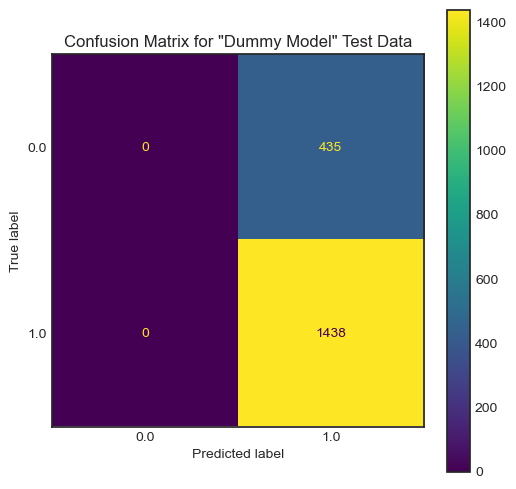

In [173]:
dummy_model.confusion_matrix()

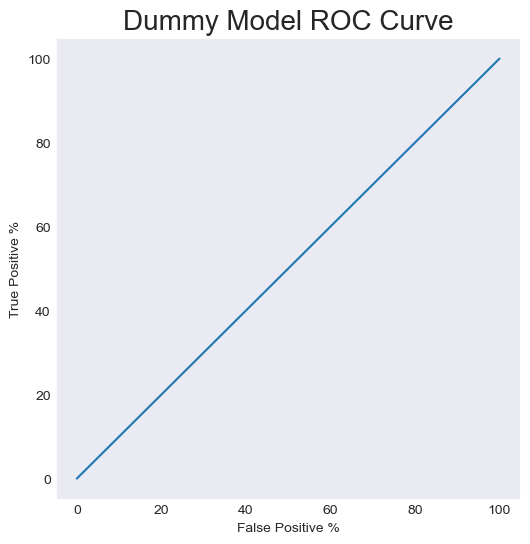

In [174]:
dummy_model.roc_curve()

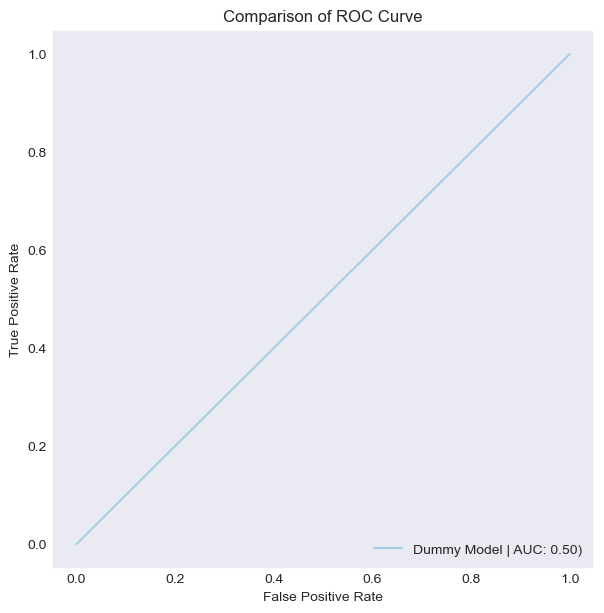

In [175]:
dummy_model.compare_roc_curve()

Model name: Dummy Model


In [177]:
lr = LogisticRegression(random_state=13, verbose=1, n_jobs=4)

In [178]:
lr.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89410D+03    |proj g|=  2.49843D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     39     51      1     0     0   2.003D+06   3.171D+03
  F =   3170.6308794745787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(n_jobs=4, random_state=13, verbose=1)

In [185]:
Log_Reg = Model("Logistic Regression with Threshold: .6", lr, X_train, X_test, y_train, y_test, threshold=.6)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/samalainabayeva/anaconda3/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11500D+03    |proj g|=  1.99508D+11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11500D+03    |proj g|=  1.99047D+11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11500D+03    |proj g|=  1.96980D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient

In [182]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.774653,0.774653,1.000000,0.873019,8.122332,0.767752,0.767752,1.000000,0.868620,8.371057,0.500000
1,Logistic Regression with Threshold: .6,0.770560,0.776196,0.988971,0.869759,0.564587,0.761345,0.771733,0.956885,0.854393,0.575303,0.447222
2,Logistic Regression with Threshold: .5,0.770560,0.776196,0.988971,0.869759,0.564587,0.761345,0.769733,0.983310,0.863511,0.575303,0.447222


In [181]:
lr2 = LogisticRegression(random_state=13, verbose=1, n_jobs=4)
lr2.fit(X_train, y_train)
Log_Reg2 = Model("Logistic Regression with Threshold: .5", lr, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89410D+03    |proj g|=  2.49843D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     39     51      1     0     0   2.003D+06   3.171D+03
  F =   3170.6308794745787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.1

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

In [187]:
rf = RandomForestClassifier(n_jobs=4, random_state=13)
rf.fit(X_train, y_train)
forest = Model("Random Forest", rf, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/ana

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/utils/validation.py:605

In [188]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.774653,0.774653,1.000000,0.873019,8.122332,0.767752,0.767752,1.000000,0.868620,8.371057,0.500000
1,Logistic Regression with Threshold: .6,0.770560,0.776196,0.988971,0.869759,0.564587,0.761345,0.771733,0.956885,0.854393,0.575303,0.447222
2,Logistic Regression with Threshold: .5,0.770560,0.776196,0.988971,0.869759,0.564587,0.761345,0.769733,0.983310,0.863511,0.575303,0.447222
3,Logistic Regression with Threshold: .6,0.770560,0.776196,0.988971,0.869759,0.564587,0.761345,0.771733,0.956885,0.854393,0.575303,0.447222
4,Random Forest,0.968138,0.975609,0.983456,0.979513,0.101946,0.962627,0.968493,0.983310,0.975845,0.097298,0.993469


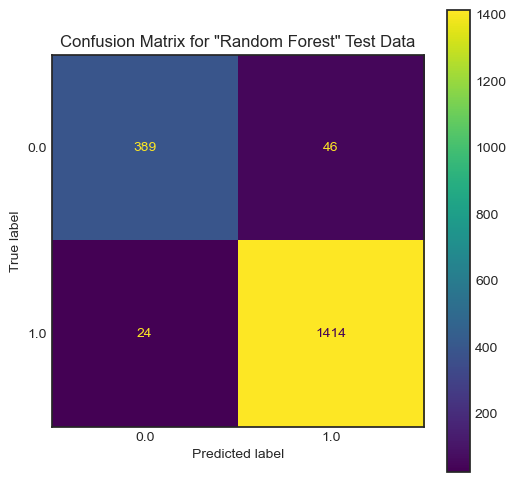

In [189]:
forest.confusion_matrix()

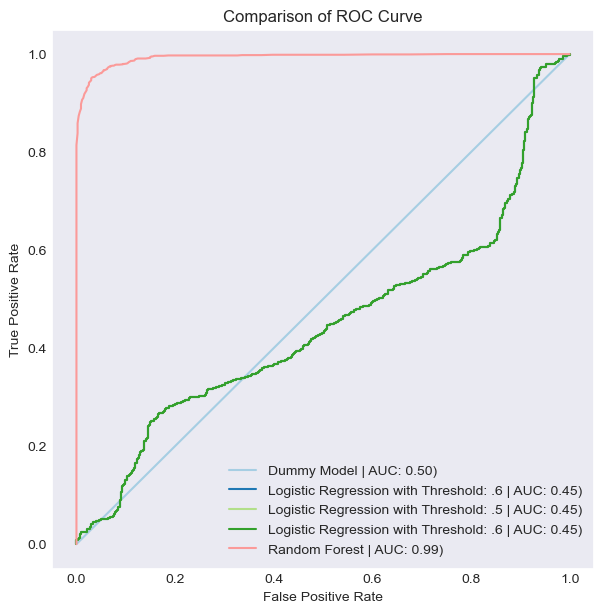

In [190]:
forest.compare_roc_curve()

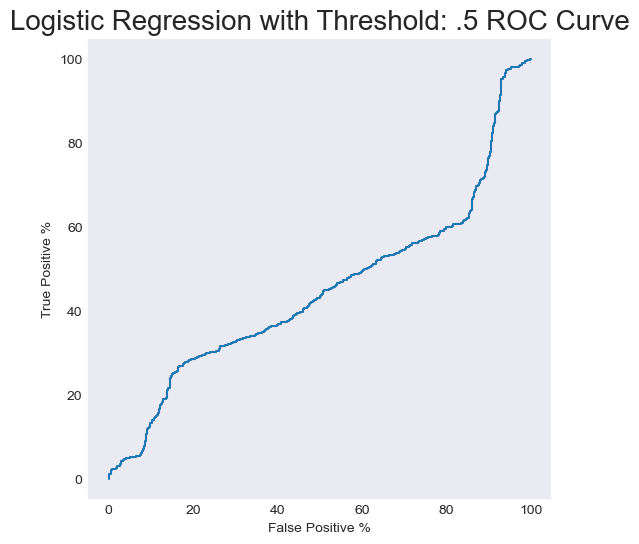

In [192]:
Log_Reg2.roc_curve()